In [1]:
import numpy as np
from numpy import ma
import pandas as pd
import math
from sklearn import metrics, linear_model
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

import tensorflow as tf
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import os
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import average_precision_score, matthews_corrcoef
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support

# Import Data

In [2]:
print(os.getcwd())
relative_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
train_df = pd.read_csv(relative_path+'/preprocessed_data/full_dataset_train_test_val_OHE/full_train_df_feats_OHE.csv')

test_df = pd.read_csv(relative_path+'/preprocessed_data/full_dataset_train_test_val_OHE/full_test_df_feats_OHE.csv')

validation_df = pd.read_csv(relative_path+'/preprocessed_data/full_dataset_train_test_val_OHE/full_val_df_feats_OHE.csv')




a:\Desktop\FYP Final Files\notebooks\Unsupervised_ML


In [3]:
train_df.head()

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,System_Core,Amazon_AWS,Container_Virtualization,Maintenance_Package_Management,Security_Monitoring,Utility_Misc,sus,evil
0,1,0,0,1,157,5,0,1,0,0,0,0,0,1,0
1,1,0,0,1,3,1,0,1,0,0,0,0,0,1,0
2,1,0,0,1,1010,0,0,1,0,0,0,0,0,1,0
3,1,1,0,0,21,2,2,0,0,0,0,0,1,1,0
4,1,1,0,0,1005,4,0,0,0,0,0,0,1,1,0


# Helpers

In [4]:
def split_data(df: pd.DataFrame) -> pd.DataFrame:
    features = df[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue",'System_Core','Amazon_AWS','Container_Virtualization','Maintenance_Package_Management','Security_Monitoring','Utility_Misc']]
    labels = df['sus']
    return features, labels

In [5]:
def print_metrics(y_true, y_predicted):

    accuracy = accuracy_score(y_true, y_predicted)   
    metrics_results = precision_recall_fscore_support(y_true, y_predicted, average="weighted", pos_label=1)
    average_precision = average_precision_score(y_true, y_predicted)
    balanced_accuracy = balanced_accuracy_score(y_true, y_predicted)
    mcc = matthews_corrcoef(y_true, y_predicted)
    
    print(f'Accuracy:\t{accuracy:.3f}')
    print(f'Precision:\t{metrics_results[0]}')
    print(f'Recall:\t\t{metrics_results[1]:.3f}')
    print(f'F1-Score:\t{metrics_results[2]:.3f}')
    print("Average Precision Score:", average_precision)
    print("Balanced Accuracy Score:", balanced_accuracy)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_true , y_predicted)))
    
    #make confusion matrix
    confusion_matrixs = confusion_matrix(y_true, y_predicted)
    

    TP = confusion_matrixs[1][1]
    TN = confusion_matrixs[0][0]
    FP = confusion_matrixs[0][1]
    FN = confusion_matrixs[1][0]


    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrixs, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

    # Print roc curve
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_predicted)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, )
    display.plot()
    plt.show()


    precision, recall, _ = precision_recall_curve(y_true, y_predicted)

    # Calculate the area under the curve
    pr_auc = auc(recall, precision)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

In [6]:
def normal_accuracy(values):
    
    tp=list(values).count(1)
    total=values.shape[0]
    accuracy=np.round(tp/total,4)
    
    return accuracy

def fraud_accuracy(values):
    
    tn=list(values).count(-1)
    total=values.shape[0]
    accuracy=np.round(tn/total,4)
    
    return accuracy

In [7]:
def prepare_labels(y_predicted):
    """
    Helper function to help map out the outputs from models that return -1 for outliers and 1 for inliners.
    """
    y_predicted[y_predicted == 1] = 0
    y_predicted[y_predicted == -1] = 1
    return y_predicted

# Split data

In [8]:
train_df_feats, train_df_labels = split_data(train_df)
test_df_feats, test_df_labels = split_data(test_df)
val_df_feats, val_df_labels = split_data(validation_df)

In [9]:
train_df_feats=train_df_feats.drop(columns="userId",axis=1)
test_df_feats=test_df_feats.drop(columns="userId",axis=1)
val_df_feats=val_df_feats.drop(columns="userId",axis=1)

In [10]:
train_df_feats.head()
train_df_feats.shape

(763144, 12)

In [11]:
train_df_labels.head()
train_df_labels.shape

(763144,)

In [12]:
train_df_feats.head()

,processId,parentProcessId,mountNamespace,eventId,argsNum,returnValue,System_Core,Amazon_AWS,Container_Virtualization,Maintenance_Package_Management,Security_Monitoring,Utility_Misc
0,1,0,1,157,5,0,1,0,0,0,0,0
1,1,0,1,3,1,0,1,0,0,0,0,0
2,1,0,1,1010,0,0,1,0,0,0,0,0
3,1,1,0,21,2,2,0,0,0,0,0,1
4,1,1,0,1005,4,0,0,0,0,0,0,1


# Model training

## Isolation forest

In [13]:
iforest = IsolationForest(random_state=0,contamination=0.05)
iforest.fit(train_df_feats)

IsolationForest(contamination=0.05, random_state=0)

In [14]:
ypred_iforest = iforest.predict(val_df_feats)
ypred_iforest = prepare_labels(ypred_iforest)
print(classification_report(val_df_labels, ypred_iforest,digits=3))

              precision    recall  f1-score   support

           0      0.997     0.960     0.978    188181
           1      0.029     0.286     0.053       786

    accuracy                          0.957    188967
   macro avg      0.513     0.623     0.515    188967
weighted avg      0.993     0.957     0.974    188967



Accuracy:	0.957
Precision:	0.9928786055433726
Recall:		0.957
F1-Score:	0.974
Average Precision Score: 0.01128489846432792
Balanced Accuracy Score: 0.6231490077909805
Matthews Correlation Coefficient (MCC): 0.07995468216741547
AUC : 0.62315


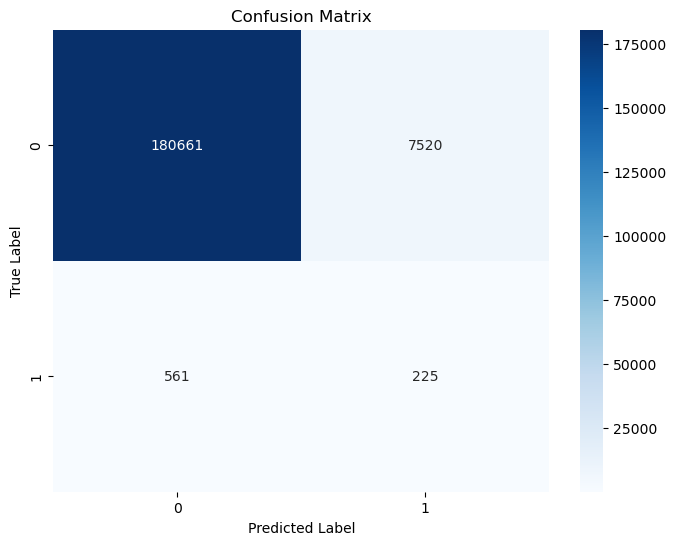

True Positives (TP): 225
True Negatives (TN): 180661
False Positives (FP): 7520
False Negatives (FN): 561


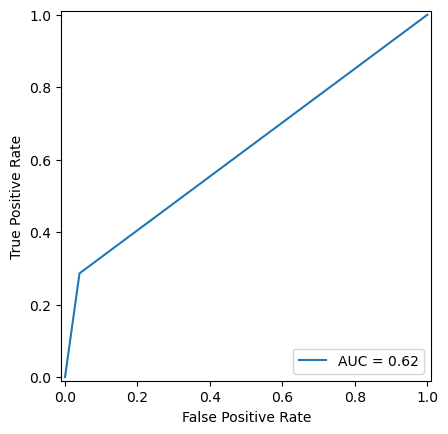

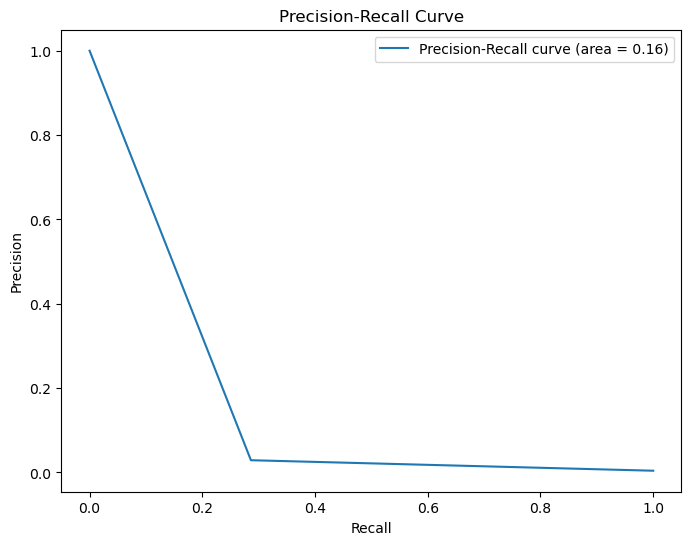

In [15]:
print_metrics(val_df_labels,ypred_iforest)

In [16]:
ypred_iforest_test = iforest.predict(test_df_feats)
ypred_iforest_test = prepare_labels(ypred_iforest_test)
print(classification_report(test_df_labels, ypred_iforest_test,digits=3))

              precision    recall  f1-score   support

           0      0.082     0.866     0.149     17508
           1      0.273     0.005     0.010    171459

    accuracy                          0.085    188967
   macro avg      0.177     0.436     0.080    188967
weighted avg      0.255     0.085     0.023    188967



Accuracy:	0.085
Precision:	0.25486837821544683
Recall:		0.085
F1-Score:	0.023
Average Precision Score: 0.9040945901941398
Balanced Accuracy Score: 0.4355653512180135
Matthews Correlation Coefficient (MCC): -0.28848813441618965
AUC : 0.43557


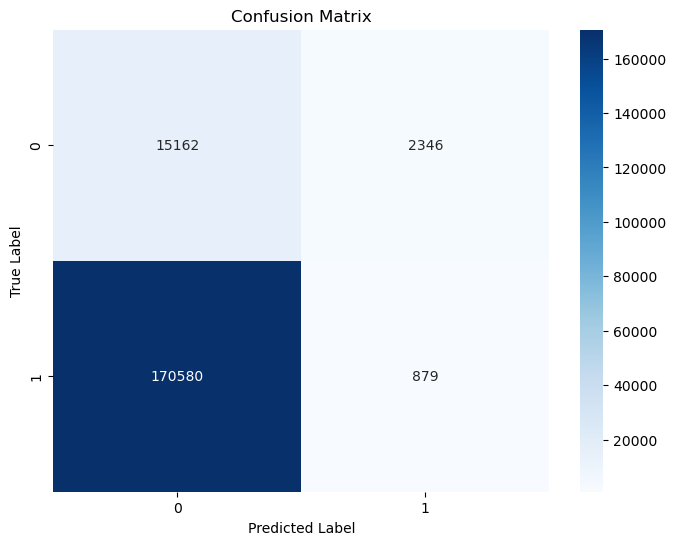

True Positives (TP): 879
True Negatives (TN): 15162
False Positives (FP): 2346
False Negatives (FN): 170580


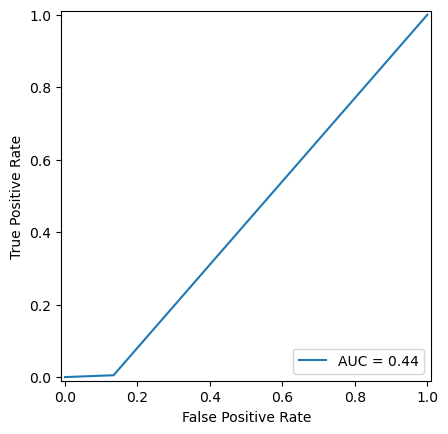

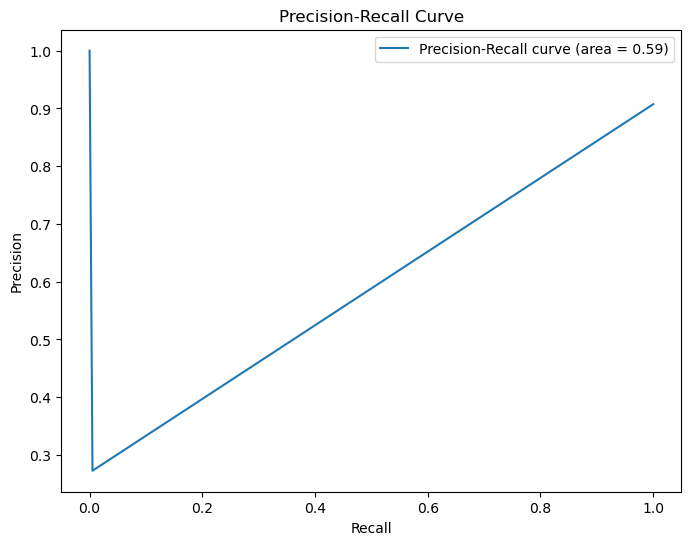

In [17]:
print_metrics(test_df_labels,ypred_iforest_test)

## Local Outlier Factor

In [18]:
lof = LocalOutlierFactor(contamination=0.05, novelty=True)
lof.fit(train_df_feats)

LocalOutlierFactor(contamination=0.05, novelty=True)

In [19]:
predicted_scores = lof.decision_function(test_df_feats)
predicted_labels = lof.predict(test_df_feats)
predicted_labels = (predicted_labels == -1).astype(int)

c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Accuracy:	0.927
Precision:	0.9311659476626868
Recall:		0.927
F1-Score:	0.929
Average Precision Score: 0.9629142868489078
Balanced Accuracy Score: 0.8105350854284366
Matthews Correlation Coefficient (MCC): 0.5893435408046793
AUC : 0.81054


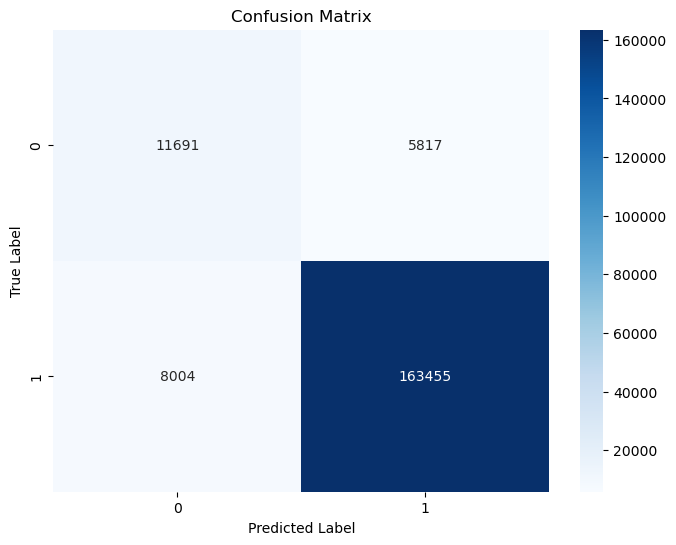

True Positives (TP): 163455
True Negatives (TN): 11691
False Positives (FP): 5817
False Negatives (FN): 8004


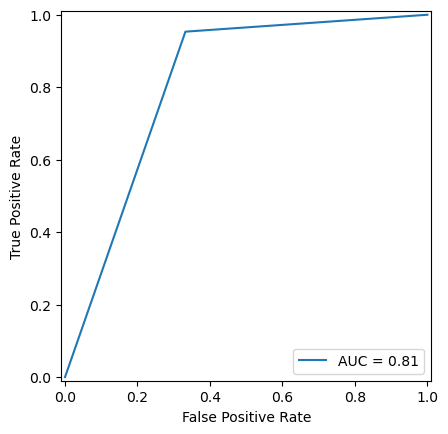

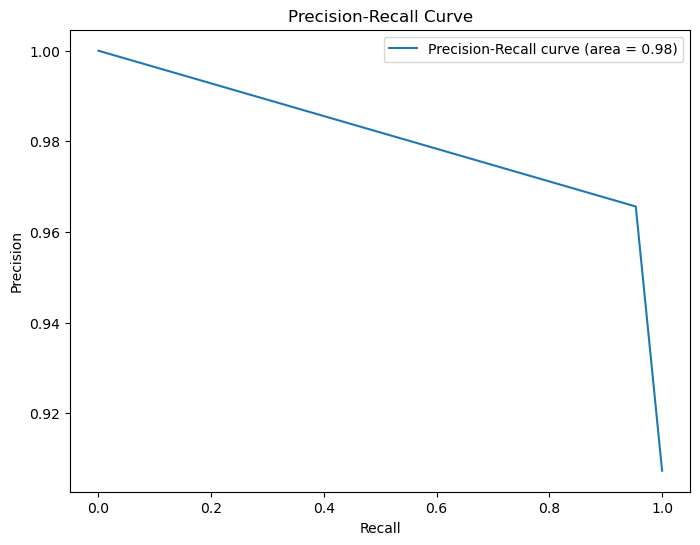

In [20]:
print_metrics(test_df_labels,predicted_labels)

In [21]:
predicted_scores = lof.decision_function(val_df_feats)
predicted_labels = lof.predict(val_df_feats)
predicted_labels = (predicted_labels == -1).astype(int)

c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Accuracy:	0.994
Precision:	0.9921583511056163
Recall:		0.994
F1-Score:	0.993
Average Precision Score: 0.006970805900290249
Balanced Accuracy Score: 0.5198471923510705
Matthews Correlation Coefficient (MCC): 0.051619062181596564
AUC : 0.51985


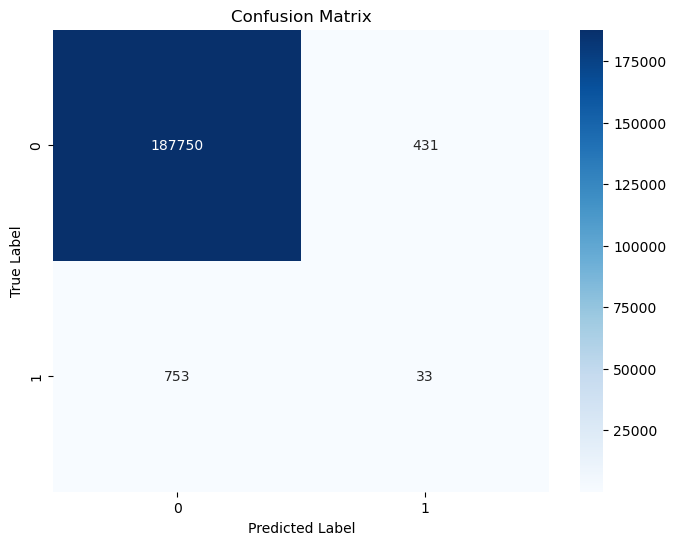

True Positives (TP): 33
True Negatives (TN): 187750
False Positives (FP): 431
False Negatives (FN): 753


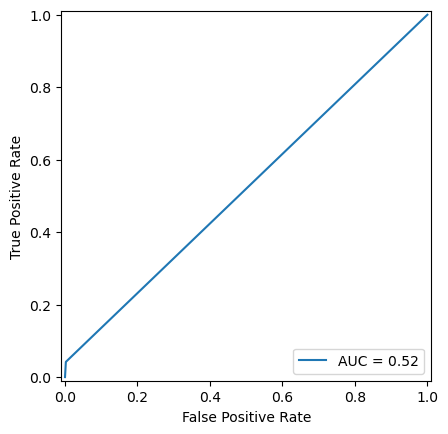

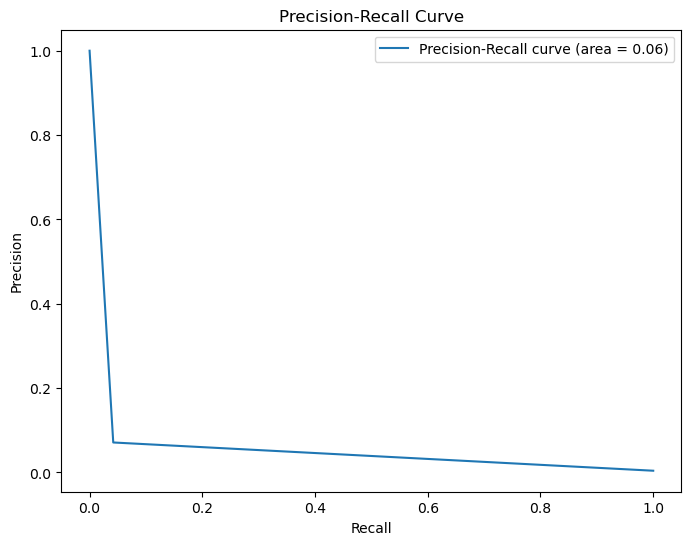

In [22]:
print_metrics(val_df_labels,predicted_labels)

## SVM

In [23]:
model = linear_model.SGDOneClassSVM(random_state=0).fit(train_df_feats)

Accuracy:	0.701
Precision:	0.9910823536166431
Recall:		0.701
F1-Score:	0.821
Average Precision Score: 0.0038757132719504897
Balanced Accuracy Score: 0.4464956306683946
Matthews Correlation Coefficient (MCC): -0.015084973443520134
AUC : 0.44650


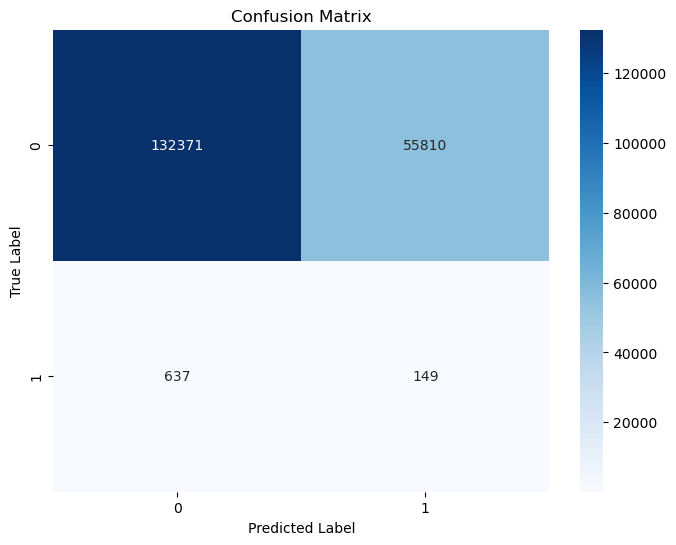

True Positives (TP): 149
True Negatives (TN): 132371
False Positives (FP): 55810
False Negatives (FN): 637


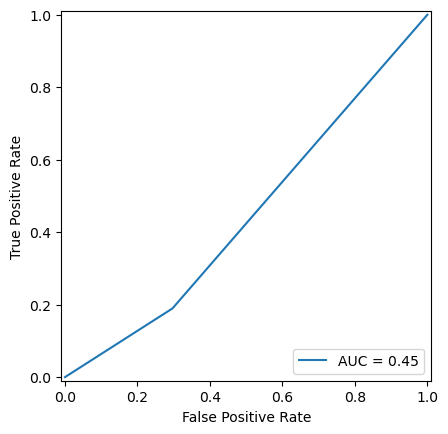

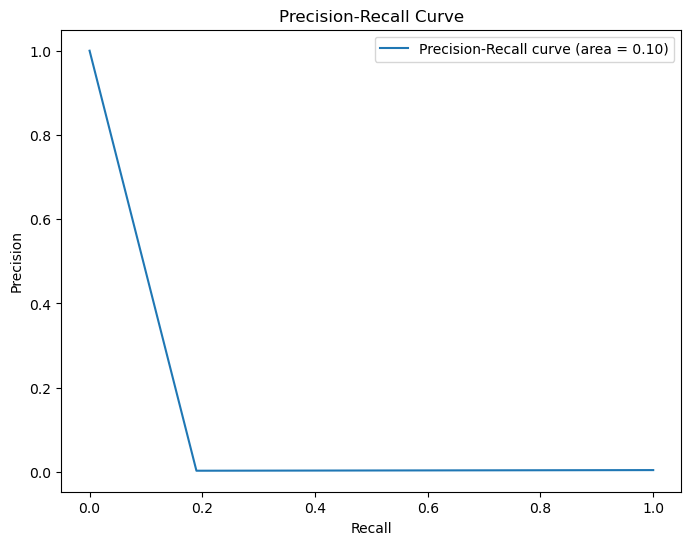

In [24]:
y_pred_svm_val = model.predict(val_df_feats)
y_pred_svm_val = prepare_labels(y_pred_svm_val)
print_metrics(val_df_labels,y_pred_svm_val)

Accuracy:	0.105
Precision:	0.5545655096019705
Recall:		0.105
F1-Score:	0.078
Average Precision Score: 0.8956140810884428
Balanced Accuracy Score: 0.39509056353714944
Matthews Correlation Coefficient (MCC): -0.26010006220217413
AUC : 0.39509


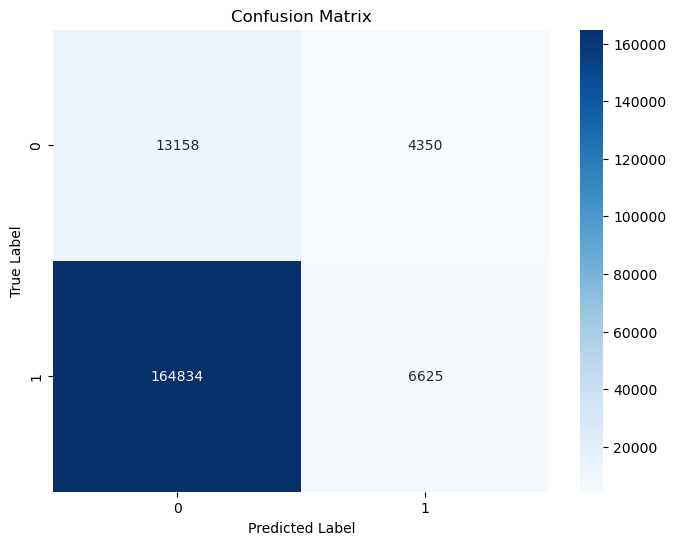

True Positives (TP): 6625
True Negatives (TN): 13158
False Positives (FP): 4350
False Negatives (FN): 164834


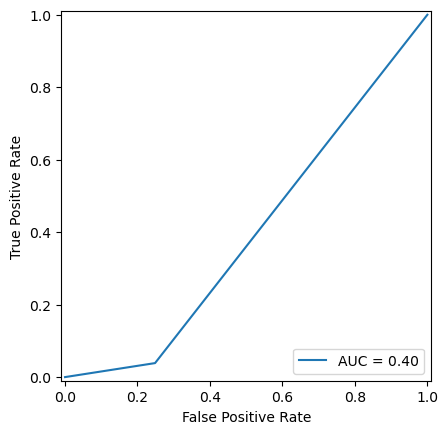

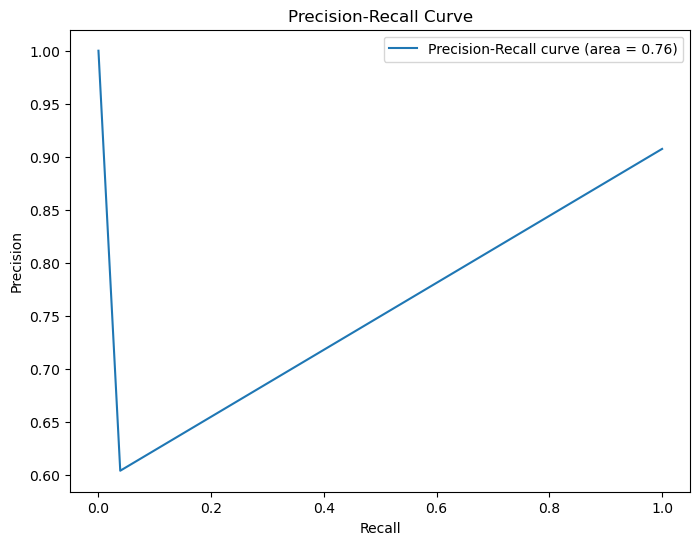

In [25]:
y_pred_svm_test = model.predict(test_df_feats)
y_pred_svm_test = prepare_labels(y_pred_svm_test)
print_metrics(test_df_labels,y_pred_svm_test)

## Autoenconder

In [26]:
input_dim = train_df_feats.shape[1] # Number of features

In [27]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

input_dim = train_df_feats.shape[1] # Number of features

# Encoder
input_layer = Input(shape=(input_dim, ))
encoder = Dense(128, activation="relu")(input_layer)
encoder = Dense(64, activation="relu")(encoder)

# Bottleneck
bottleneck = Dense(32, activation="relu")(encoder)

# Decoder
decoder = Dense(64, activation="relu")(bottleneck)
decoder = Dense(128, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [28]:
checkpoint = ModelCheckpoint("best_weights3.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = autoencoder.fit(
    train_df_feats, train_df_feats,
    epochs=20,
    batch_size=256,
    validation_data=(val_df_feats, val_df_feats),
    shuffle=True,
    callbacks=[checkpoint]
)
autoencoder.load_weights("best_weights3.keras")

Epoch 1/20
2977/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 432.6845
Epoch 1: val_loss improved from inf to 0.08374, saving model to best_weights3.keras
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 431.9507 - val_loss: 0.0837
Epoch 2/20
2974/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0494
Epoch 2: val_loss improved from 0.08374 to 0.02690, saving model to best_weights3.keras
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0496 - val_loss: 0.0269
Epoch 3/20
2967/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2429
Epoch 3: val_loss improved from 0.02690 to 0.02405, saving model to best_weights3.keras
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2428 - val_loss: 0.0241
Epoch 4/20
2958/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2962
Epoch 4: val_loss improved from 0.02405 to 0.02053, saving model to best_weights3.keras
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2963 - val_loss: 0.0205
Epoch 5/20
2971/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

In [29]:
# Predict on the test set
X_test_pred = autoencoder.predict(test_df_feats)
# Predict on the val set
X_val_pred = autoencoder.predict(val_df_feats)

X_train_pred = autoencoder.predict(train_df_feats)

5906/5906 ━━━━━━━━━━━━━━━━━━━━ 5s 757us/step
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 4s 680us/step
23849/23849 ━━━━━━━━━━━━━━━━━━━━ 17s 696us/step


In [30]:
mse_train = np.mean(np.power(train_df_feats - X_train_pred, 2), axis=1)
mse_test = np.mean(np.power(test_df_feats - X_test_pred, 2), axis=1)
mse_val = np.mean(np.power(val_df_feats - X_val_pred, 2), axis=1)

In [31]:

threshold = np.quantile(mse_train, 0.99)

# Predict anomalies on the test set
y_pred_test = (mse_test > threshold)
y_pred_test = y_pred_test.astype(int)

In [32]:
y_pred_val = (mse_val > threshold)
y_pred_val = y_pred_val.astype(int)

In [33]:
from sklearn.metrics import classification_report, roc_auc_score

# Calculate classification metrics
print(classification_report(test_df_labels, y_pred_test))

# Calculate AUC-ROC
roc_auc = roc_auc_score(test_df_labels, mse_test) # Using raw MSE scores for AUC calculation
print(f"AUC-ROC: {roc_auc:.2f}")

              precision    recall  f1-score   support

           0       0.42      0.77      0.55     17508
           1       0.97      0.89      0.93    171459

    accuracy                           0.88    188967
   macro avg       0.70      0.83      0.74    188967
weighted avg       0.92      0.88      0.90    188967

AUC-ROC: 0.89


Accuracy:	0.881
Precision:	0.9231912409893419
Recall:		0.881
F1-Score:	0.896
Average Precision Score: 0.9671299375285044
Balanced Accuracy Score: 0.8311138440964198
Matthews Correlation Coefficient (MCC): 0.5125617981803845
AUC : 0.83111


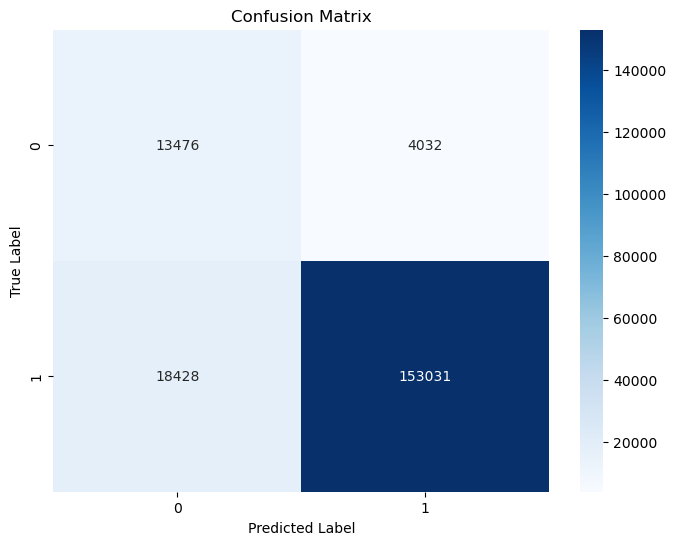

True Positives (TP): 153031
True Negatives (TN): 13476
False Positives (FP): 4032
False Negatives (FN): 18428


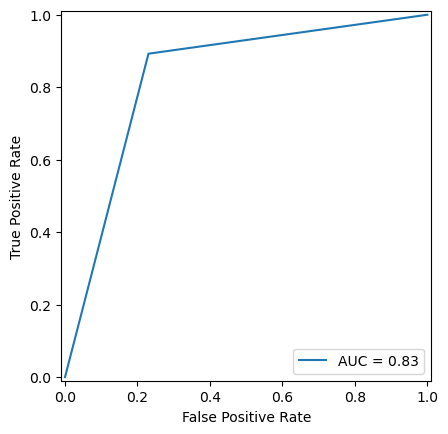

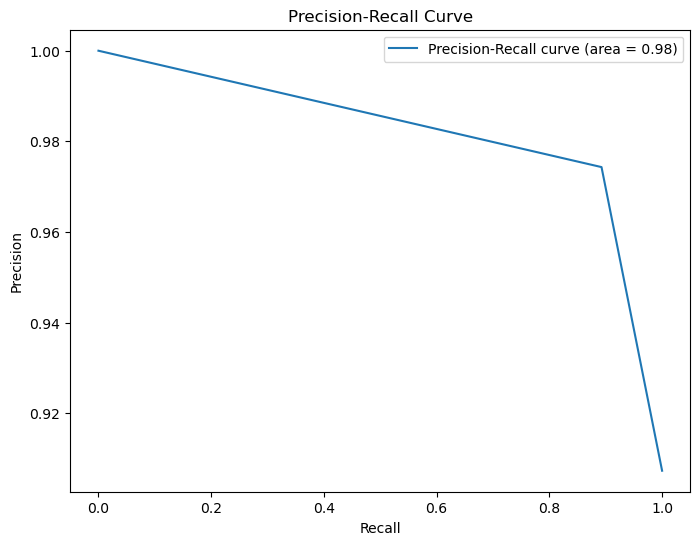

In [34]:
print_metrics(test_df_labels,y_pred_test)

In [35]:
from sklearn.metrics import classification_report, roc_auc_score

# Calculate classification metrics
print(classification_report(val_df_labels, y_pred_val))

# Calculate AUC-ROC
roc_auc = roc_auc_score(test_df_labels, mse_val) # Using raw MSE scores for AUC calculation
print(f"AUC-ROC: {roc_auc:.2f}")

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    188181
           1       0.00      0.02      0.01       786

    accuracy                           0.98    188967
   macro avg       0.50      0.50      0.50    188967
weighted avg       0.99      0.98      0.99    188967

AUC-ROC: 0.54


Accuracy:	0.981
Precision:	0.9917230579018164
Recall:		0.981
F1-Score:	0.986
Average Precision Score: 0.004165709403133651
Balanced Accuracy Score: 0.5006919093770003
Matthews Correlation Coefficient (MCC): 0.0007288539935202284
AUC : 0.50069


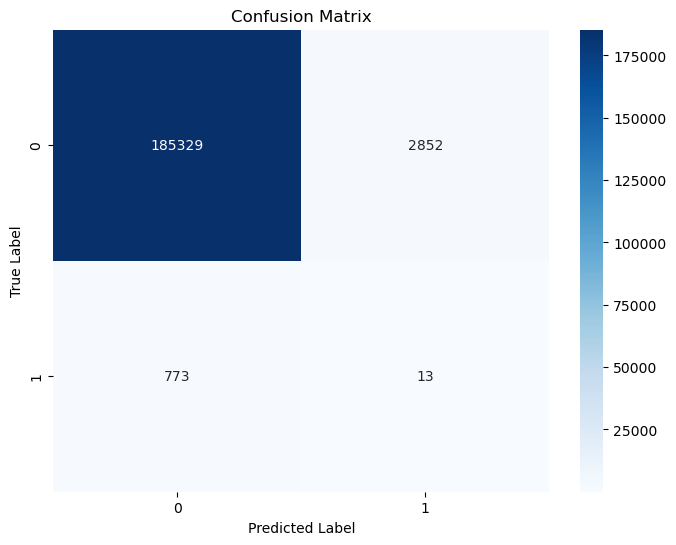

True Positives (TP): 13
True Negatives (TN): 185329
False Positives (FP): 2852
False Negatives (FN): 773


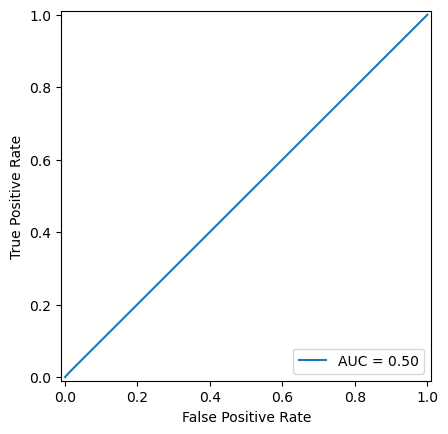

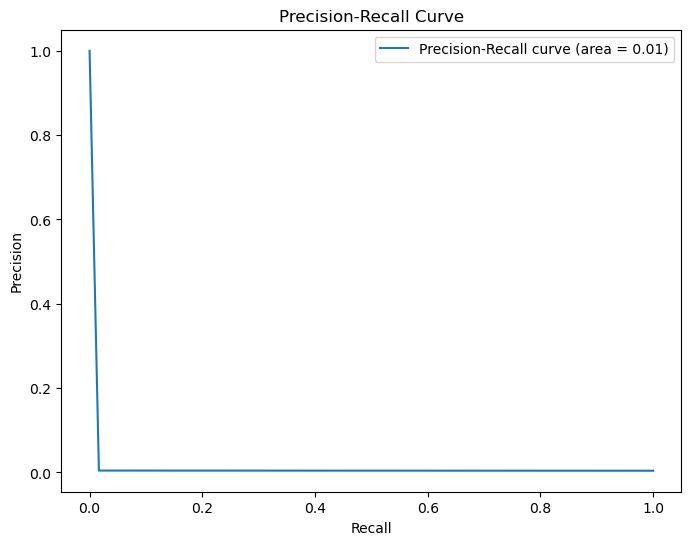

In [36]:
print_metrics(val_df_labels,y_pred_val)